In [11]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from custom_train_tools import FcLayer, WaveNET
from collections import deque
from itertools import chain

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mean = np.load("mean.npy")
std = np.load("std.npy")

Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad
g = 9.8
number_of_radar_samples = 20
K_alt = .8*2          # hdot loop gain
RoC = 20              # maximum rate of climb (max. of hdot)
AoA0 = -1.71*Deg2Rad     # zero lift angle of attack
Acc2AoA = 0.308333*Deg2Rad  # 1m/s^2 ACC corresponds to 0.308333deg AOA
zeta_ap = 0.7         # pitch acceleration loop damping
omega_ap = 4          # pitch acceleration loop bandwidth
dist_sep = 100        # near mid-air collision range

model_test = torch.load("./res_model/Custom_model_100_800_1600_2_8_3_0_no_noise_fin.pth")
model_test.eval()

# hdot loop dynamics definition

def model(z, t, hdot_cmd):                          # computes state derivatives
    Vm = 200
    # state vector: a (pitch acc), adot, h (alt), hdot, R (ground-track range)
    a, adot, h, hdot, R = z
    gamma = np.arcsin(hdot/Vm)                          # fight path angle
    # pitch acceleration command
    ac = K_alt * (hdot_cmd - hdot) + g/np.cos(gamma)
    ac = np.clip(ac, -30, 30)                         # maneuver limit

    addot = omega_ap*omega_ap*(ac-a) - 2*zeta_ap*omega_ap*adot
    hddot = a*np.cos(gamma) - g
    Rdot = Vm*np.cos(gamma)
    # returns state derivatives
    return np.array([adot, addot, hdot, hddot, Rdot])

dt = 0.1              # control frequency
tf = 20               # final time
t = np.arange(0, tf, dt)
stop_point = random.randrange(number_of_radar_samples, len(t))
N = len(t)

hm0 = 1000                                                     # initial altitude
Vm = 200                                                       # initial speed
# initial flight path angle
gamma0 = 0*Deg2Rad
# initial NED position
Pm_NED = np.array([0, 0, -hm0])
# initial NED velocity
Vm_NED = np.array([Vm*np.cos(gamma0), 0, -Vm*np.sin(gamma0)])

# state variable: [a, adot, h, hdot, R]
X0 = np.array([g/np.cos(gamma0), 0, hm0, -Vm_NED[2], 0]
              )       # initial state vector

# target initial conditions
ht0 = 1000 + 200*np.random.randn()
Vt = 200
approach_angle = 50*Deg2Rad*(2*np.random.rand()-1)
psi0 = np.pi + approach_angle + 2*np.random.randn()*Deg2Rad
psi0 = np.arctan2(np.sin(psi0), np.cos(psi0))

Pt_N = 2000*(1+np.cos(approach_angle))
Pt_E = 2000*np.sin(approach_angle)
Pt_D = -ht0
# initial NED position
Pt_NED = np.array([Pt_N, Pt_E, Pt_D])
# initial NED velocity
Vt_NED = np.array([Vt*np.cos(psi0), Vt*np.sin(psi0), 0])

# initialize variables
X = np.zeros((N, len(X0)))
X[0, :] = X0
dotX_p = 0

theta0 = gamma0 + X0[0]*Acc2AoA + AoA0  # initial pitch angle

DCM = np.zeros((3, 3))                      # initial DCM NED-to-Body
DCM[0, 0] = np.cos(theta0)
DCM[0, 2] = -np.sin(theta0)
DCM[1, 1] = 1
DCM[2, 0] = np.sin(theta0)
DCM[2, 2] = np.cos(theta0)

Pr_NED = Pt_NED - Pm_NED                   # relative NED position
Vr_NED = Vt_NED - Vm_NED                   # relative NED velosity

# relative position (Body frame)
Pr_Body = np.dot(DCM, Pr_NED)

# radar outputs
r = np.linalg.norm(Pr_Body)                # range
vc = -np.dot(Pr_NED, Vr_NED)/r             # closing velocity
# target vertival look angle (down +)
elev = np.arctan2(Pr_Body[2], Pr_Body[0])
# target horizontal look angle (right +)
azim = np.arctan2(Pr_Body[1], Pr_Body[0]/np.cos(theta0))

los = theta0 - elev                        # line of sight angle
dlos = 0
daz = 0

# static variables
hdot_cmd = 0
count_change_hdot = 0

# list to save several length of radar data
radar_data = []
# list to save real radar data
real_radar_data = []
# list to save real data
real_data = []

# main loop
for k in range(N-1):
    ##############################################################################
    # UPDATE ENVIRONMENT AND GET OBSERVATION

    # update environment
    # adams-bashforth 2nd order integration
    dotX = model(X[k, :], t[k], hdot_cmd)
    X[k+1, :] = X[k, :] + 0.5*(3*dotX-dotX_p)*dt
    dotX_p = dotX

    Pt_NED = Pt_NED + Vt_NED*dt        # target position integration

    # get observation

    a, adot, h, hdot, R = X[k+1, :]

    gamma = np.arcsin(hdot/Vm)
    theta = gamma + a*Acc2AoA + AoA0

    DCM = np.zeros((3, 3))
    DCM[0, 0] = np.cos(theta)
    DCM[0, 2] = -np.sin(theta)
    DCM[1, 1] = 1
    DCM[2, 0] = np.sin(theta)
    DCM[2, 2] = np.cos(theta)

    Pm_NED = np.array([R, 0, -h])
    Vm_NED = np.array([Vm*np.cos(gamma), 0, -Vm*np.sin(gamma)])

    Pr_NED = Pt_NED - Pm_NED
    Vr_NED = Vt_NED - Vm_NED

    Pr_Body = np.dot(DCM, Pr_NED)

    r = np.linalg.norm(Pr_Body)
    vc = -np.dot(Pr_NED, Vr_NED)/r
    elev = np.arctan2(Pr_Body[2], Pr_Body[0])
    azim = np.arctan2(Pr_Body[1], Pr_Body[0]/np.cos(theta))

    psi = np.arctan2(Vt_NED[1], Vt_NED[0])

    # los rate and az rate estimation
    los = theta - elev

    # real rate of LOS
    dlos = (Pr_NED[0] * Vr_NED[2] - Pr_NED[2] * Vr_NED[0])/(Pr_NED[0]**2 + Pr_NED[2]**2 + Pr_NED[1]**2)
    # real rate of azim
    daz = (Pr_NED[0] * Vr_NED[1] - Pr_NED[1] * Vr_NED[0])/(Pr_NED[0]**2 + Pr_NED[1]**2 + Pr_NED[2]**2)

    # estimate closest approach
    min_dist_vert = r*r/vc*dlos
    min_dist_horiz = r*r/vc*daz

    # estimate cruise distance
    dist_cruise = r*los

    # save radar data with noise
#     radar_data.append([theta + np.random.randn() * Deg2Rad, elev + np.random.randn() * Deg2Rad, azim + np.random.randn() * Deg2Rad,
#                        r + 0.01 * r * np.random.randn(), vc + 0.001 * r * np.random.randn()])
    # save radar data without noise
    radar_data.append([theta, elev, azim,
                       r, vc])
    # save real data
    real_data.append([r, vc, los, daz, dlos])
    # save real radar data
    real_radar_data.append([theta, elev, azim, r, vc])

    ##############################################################################
    # COMPUTE ACTION (BEGIN)
    if k > 3 and r > dist_sep and abs(elev) < 40*Deg2Rad and abs(azim) < 40*Deg2Rad:
        if min_dist_vert > 0:
            if min_dist_vert < dist_sep:
                if np.abs(dist_cruise) < dist_sep:
                    if min_dist_horiz < dist_sep:
                        hdot_cmd = -20
                    else:
                        hdot_cmd = 0
                else:
                    hdot_cmd = 0
            else:
                if np.abs(dist_cruise) > dist_sep:
                    hdot_cmd = 0
                else:
                    hdot_cmd = -20
        else:
            if min_dist_vert > -dist_sep:
                if np.abs(dist_cruise) < dist_sep:
                    if min_dist_horiz < dist_sep:
                        hdot_cmd = 20
                    else:
                        hdot_cmd = 0
                else:
                    hdot_cmd = 0
            else:
                if np.abs(dist_cruise) > dist_sep:
                    hdot_cmd = 0
                else:
                    hdot_cmd = 20
    elif k > 3:
        break

In [12]:
radar_data = np.array(radar_data)
real_data = np.array(real_data)
real_radar_data = np.array(real_radar_data)

In [13]:
predicted_data = np.zeros((1, 5))

In [14]:
input_data = torch.Tensor((real_radar_data-mean)/std)

In [15]:
for i in range (len(radar_data) - 20):
    predicted_data = np.vstack([predicted_data, 
                               model_test(input_data[i:i+20,:].view(1,-1).to(device)).detach().cpu().numpy()])

In [16]:
predicted_data = np.delete(predicted_data, 0, axis = 0)

In [17]:
time_step = np.arange(len(radar_data))
time_step_for_predict = np.arange(20, len(predicted_data)+20)

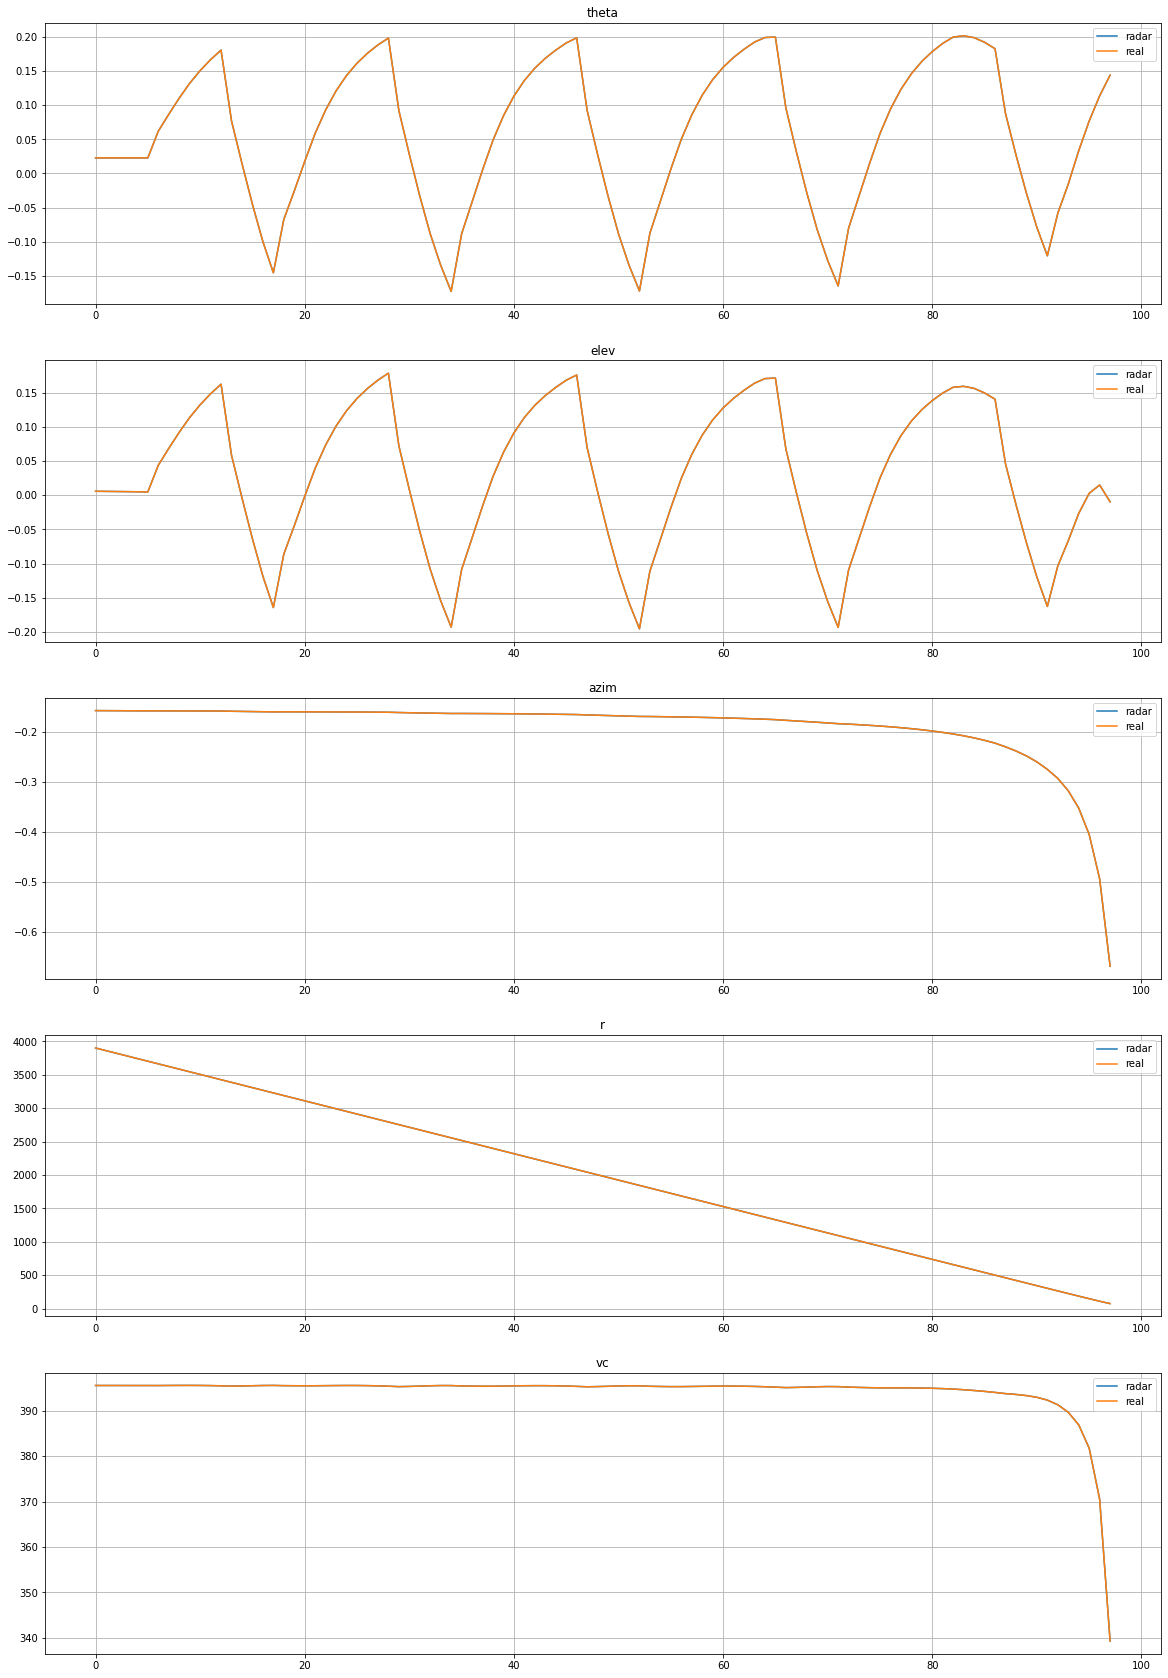

In [18]:
plt.figure(figsize = (20, 30))
plt.subplot(511)
plt.title("theta")
plt.plot(time_step, radar_data[:, 0], label = "radar")
plt.plot(time_step, real_radar_data[:, 0], label = "real")
plt.grid()
plt.legend()

plt.subplot(512)
plt.title("elev")
plt.plot(time_step, radar_data[:, 1], label = "radar")
plt.plot(time_step, real_radar_data[:, 1], label = "real")
plt.grid()
plt.legend()

plt.subplot(513)
plt.title("azim")
plt.plot(time_step, radar_data[:, 2], label = "radar")
plt.plot(time_step, real_radar_data[:, 2], label = "real")
plt.grid()
plt.legend()

plt.subplot(514)
plt.title("r")
plt.plot(time_step, radar_data[:, 3], label = "radar")
plt.plot(time_step, real_radar_data[:, 3], label = "real")
plt.grid()
plt.legend()

plt.subplot(515)
plt.title("vc")
plt.plot(time_step, radar_data[:, 4], label = "radar")
plt.plot(time_step, real_radar_data[:, 4], label = "real")
plt.grid()
plt.legend()

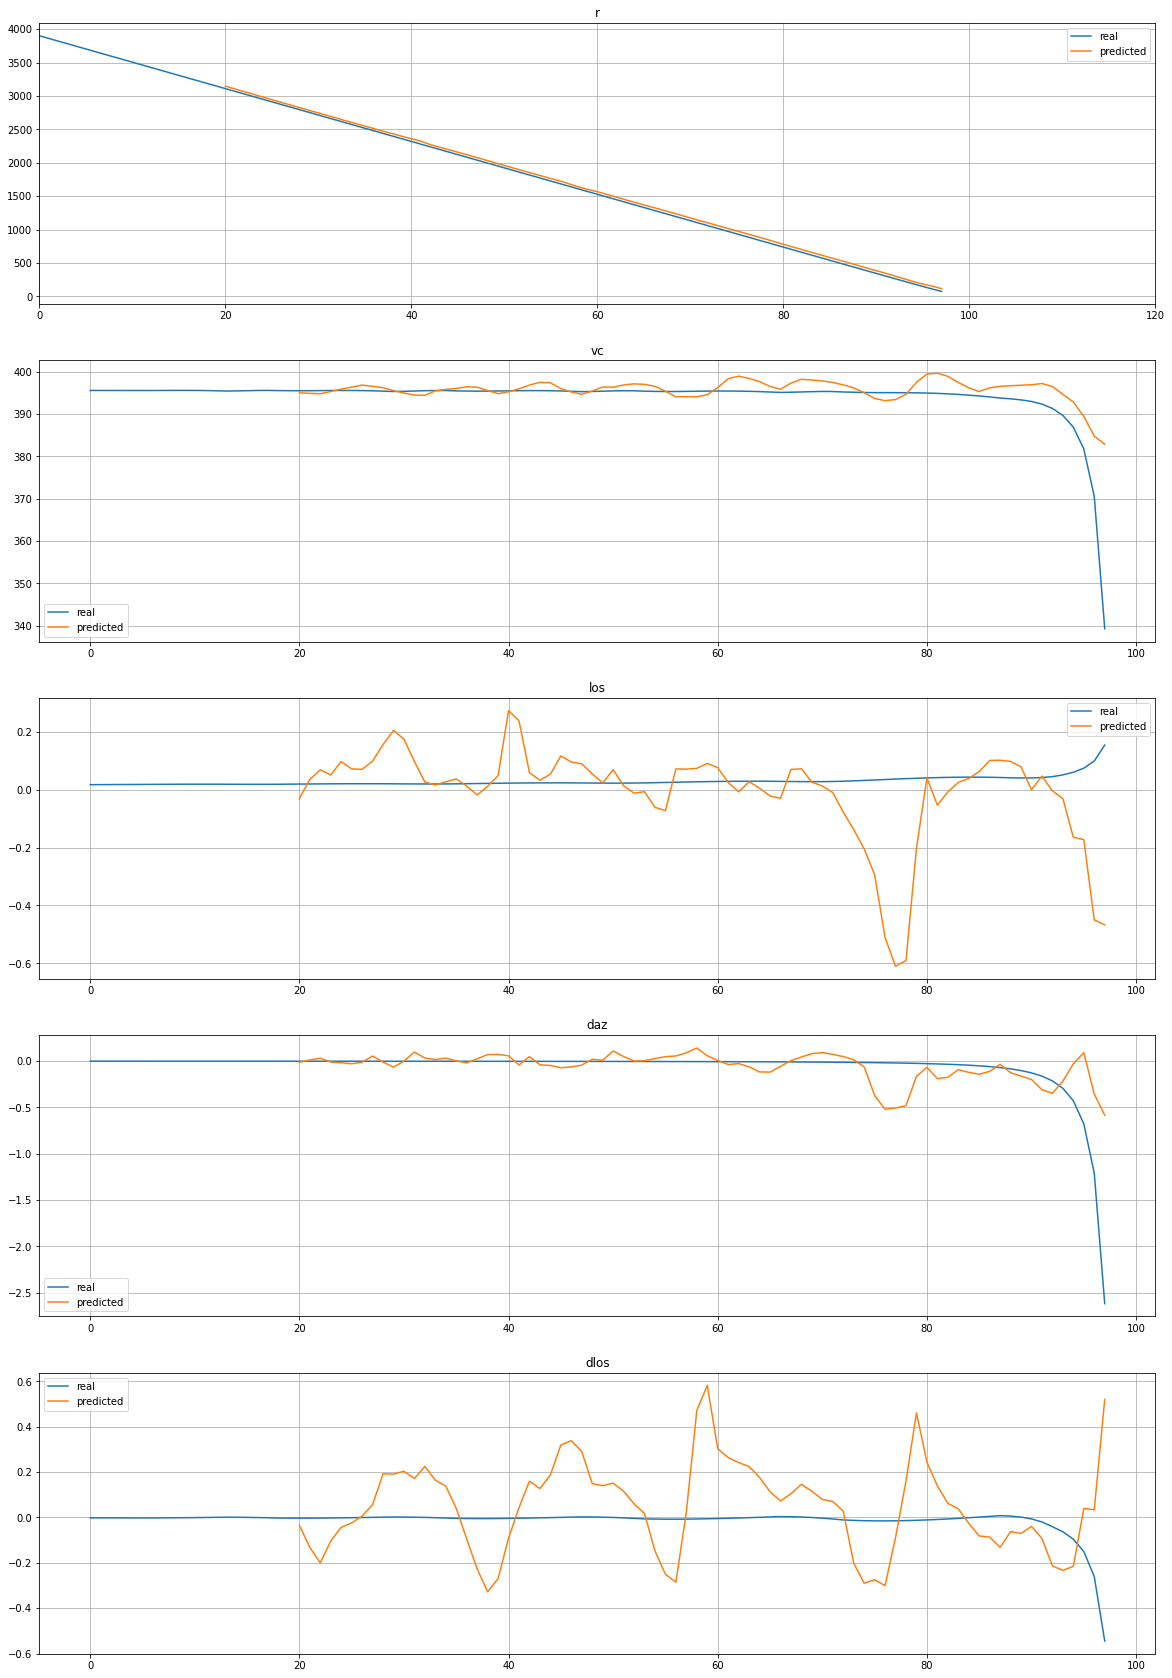

In [19]:
plt.figure(figsize = (20, 30))
plt.subplot(511)
plt.title("r")
plt.plot(time_step, real_data[:, 0], label = "real")
plt.plot(time_step_for_predict, predicted_data[:, 0], label = "predicted")
plt.xlim(0,120)
plt.grid()
plt.legend()

plt.subplot(512)
plt.title("vc")
plt.plot(time_step, real_data[:, 1], label = "real")
plt.plot(time_step_for_predict, predicted_data[:, 1], label = "predicted")
plt.grid()
plt.legend()

plt.subplot(513)
plt.title("los")
plt.plot(time_step, real_data[:, 2], label = "real")
plt.plot(time_step_for_predict, predicted_data[:, 2], label = "predicted")
plt.grid()
plt.legend()

plt.subplot(514)
plt.title("daz")
plt.plot(time_step, real_data[:, 3], label = "real")
plt.plot(time_step_for_predict, predicted_data[:, 3], label = "predicted")
plt.grid()
plt.legend()

plt.subplot(515)
plt.title("dlos")
plt.plot(time_step, real_data[:, 4], label = "real")
plt.plot(time_step_for_predict, predicted_data[:, 4], label = "predicted")
plt.grid()
plt.legend()